In [13]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [14]:
## to do list: sort out whether you just fit the line for one example or for lots of examples
## work out what the backpropagation stuff does... (bacwards in most classes)
## make a model that actually predicts at the moment it is way out.

In [15]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Repressilator ODE system
def repressilator(t, y, degredation_rate, gene_expression_rate, repression_strength, n):
    p1, r1, p2, r2, p3, r3 = y

    def protein_ODE(p, r, degredation_rate):
        return - degredation_rate * (p - r)

    def mRNA_ODE(r, repressor_protein, gene_expression_rate, repression_strength, n):
        return - r + (repression_strength / (1 + repressor_protein ** n)) + gene_expression_rate

    dp1dt = protein_ODE(p1, r1, degredation_rate)
    dr1dt = mRNA_ODE(r1, p3, gene_expression_rate, repression_strength, n)
    dp2dt = protein_ODE(p2, r2, degredation_rate)
    dr2dt = mRNA_ODE(r2, p1, gene_expression_rate, repression_strength, n)
    dp3dt = protein_ODE(p3, r3, degredation_rate)
    dr3dt = mRNA_ODE(r3, p2, gene_expression_rate, repression_strength, n)

    return dp1dt, dr1dt, dp2dt, dr2dt, dp3dt, dr3dt

# Specify the parameters
degredation_rate = 1  # beta
gene_expression_rate = 1  # alpha 0
repression_strength = 50  # alpha
n = 2  # Hill coefficient
t_span = (0, 100)
t_eval = np.linspace(0, 100, 500)

# Initial concentrations
P1 = 5
P2 = 1
P3 = 0
R1 = 0
R2 = 0
R3 = 0

# Numerical solving of system of ODEs using solve_ivp
solution = solve_ivp(repressilator, t_span, [P1, P2, P3, R1, R2, R3], t_eval=t_eval, args=(degredation_rate, gene_expression_rate, repression_strength, n))

t = solution.t
Protein_1 = solution.y[0]
Protein_2 = solution.y[1]
Protein_3 = solution.y[2]

sequence_length = 5

# Create sequences
sequence_length = 5

def create_sequences(t, protein_data, sequence_length):
    X = []
    y = []
    for i in range(len(t) - sequence_length):
        X.append(protein_data[i:i + sequence_length])
        y.append(protein_data[i + sequence_length])
    return np.array(X), np.array(y)

# Normalize the data
t_max = np.max(t)
protein_max = np.max([Protein_1, Protein_2, Protein_3])
Protein_data = np.vstack((Protein_1, Protein_2, Protein_3)).T / protein_max

# Create input-output pairs
X_train, y_train = create_sequences(t / t_max, Protein_data, sequence_length)

# Trim the time and protein data to match the length of X_train
t_trimmed = t[:X_train.shape[0] + sequence_length]
Protein_1_trimmed = Protein_1[:X_train.shape[0] + sequence_length]
Protein_2_trimmed = Protein_2[:X_train.shape[0] + sequence_length]
Protein_3_trimmed = Protein_3[:X_train.shape[0] + sequence_length]


# Neural Network
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Activation_sigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output =  1 / (1 + np.exp(-inputs))
    def backward(self, dvalues):
        self.dinputs = dvalues * (self.output * (1 - self.output))
        
class Activation_tanh:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = (np.exp(inputs)-np.exp(-inputs))/(np.exp(inputs)+np.exp(-inputs))
    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output ** 2)

        
class Loss_MeanSquaredError:
    def calculate(self, predictions, targets):
        sample_losses = np.mean((predictions - targets) ** 2, axis=-1)
        data_loss = np.mean(sample_losses)
        return data_loss
    def backward(self, dvalues, targets):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = 2 * (dvalues - targets) / outputs
        self.dinputs = self.dinputs # / samples


In [16]:
## trying with mini-batches

In [17]:
# Define the batch size
batch_size = 50

# Neural Network Architecture
dense1 = Layer_Dense(X_train.shape[1] * X_train.shape[2], 300)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(300, 300)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(300, 300)
activation3 = Activation_ReLU()
dense4 = Layer_Dense(300, y_train.shape[1])

print(dense1.biases.shape)
print(X_train.shape[1])
print(X_train.shape[2])
print(y_train.shape)

(1, 300)
5
3
(495, 3)


In [18]:
loss_function = Loss_MeanSquaredError()

learning_rate = 0.001
epochs = 100
epoch_data = []
loss_history = []

# Helper function to create mini-batches
def create_mini_batches(X, y, batch_size):
    mini_batches = []
    data = np.hstack((X.reshape(X.shape[0], -1), y))
    np.random.shuffle(data)
    n_minibatches = data.shape[0] // batch_size
    for i in range(n_minibatches):
        mini_batch = data[i * batch_size:(i + 1) * batch_size, :]
        X_mini = mini_batch[:, :-y.shape[1]].reshape(-1, X_train.shape[1], X_train.shape[2])
        y_mini = mini_batch[:, -y.shape[1]:]
        mini_batches.append((X_mini, y_mini))
    if data.shape[0] % batch_size != 0:
        mini_batch = data[n_minibatches * batch_size:, :]
        X_mini = mini_batch[:, :-y.shape[1]].reshape(-1, X_train.shape[1], X_train.shape[2])
        y_mini = mini_batch[:, -y.shape[1]:]
        mini_batches.append((X_mini, y_mini))
    return mini_batches


for epoch in range(epochs):
    mini_batches = create_mini_batches(X_train, y_train, batch_size)
    epoch_loss = 0
    for mini_batch in mini_batches:
        X_mini, y_mini = mini_batch
        # Forward pass
        dense1.forward(X_mini.reshape(X_mini.shape[0], -1))
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
        dense3.forward(activation2.output)
        activation3.forward(dense3.output)
        dense4.forward(activation3.output)
        predictions = dense4.output

        # Calculate the loss
        loss = loss_function.calculate(predictions, y_mini)
        epoch_loss += loss

        # Backpropagation
        loss_function.backward(predictions, y_mini)
        dense4.backward(loss_function.dinputs)
        activation3.backward(dense4.dinputs)
        dense3.backward(activation3.dinputs)
        activation2.backward(dense3.dinputs)
        dense2.backward(activation2.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)

        # Update weights and biases
        dense4.weights -= learning_rate * dense4.dweights
        dense4.biases -= learning_rate * dense4.dbiases
        dense3.weights -= learning_rate * dense3.dweights
        dense3.biases -= learning_rate * dense3.dbiases
        dense2.weights -= learning_rate * dense2.dweights
        dense2.biases -= learning_rate * dense2.dbiases
        dense1.weights -= learning_rate * dense1.dweights
        dense1.biases -= learning_rate * dense1.dbiases

    epoch_loss /= len(mini_batches)
    if epoch % 10 == 0:
        epoch_data.append(epoch)
        loss_history.append(epoch_loss)
        print(f'Epoch {epoch}, Loss: {epoch_loss}')

Epoch 0, Loss: 0.043543245845701226
Epoch 10, Loss: 0.0002536118467934286
Epoch 20, Loss: 0.00015057253169894672
Epoch 30, Loss: 0.0001052329300900267
Epoch 40, Loss: 8.271662876134467e-05
Epoch 50, Loss: 6.405314720651508e-05
Epoch 60, Loss: 5.150724826023771e-05
Epoch 70, Loss: 4.447027116493326e-05
Epoch 80, Loss: 3.7564040654936186e-05
Epoch 90, Loss: 3.2154596987655915e-05


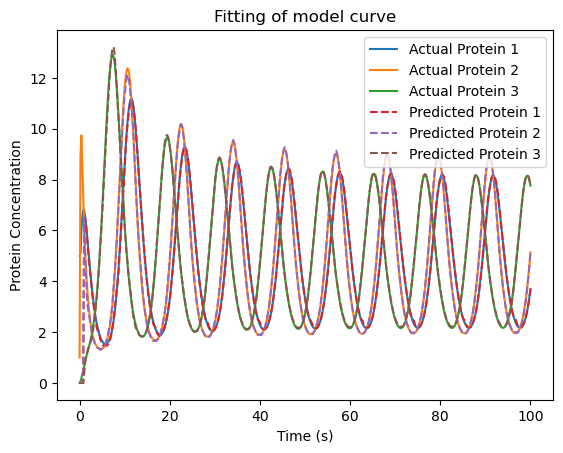

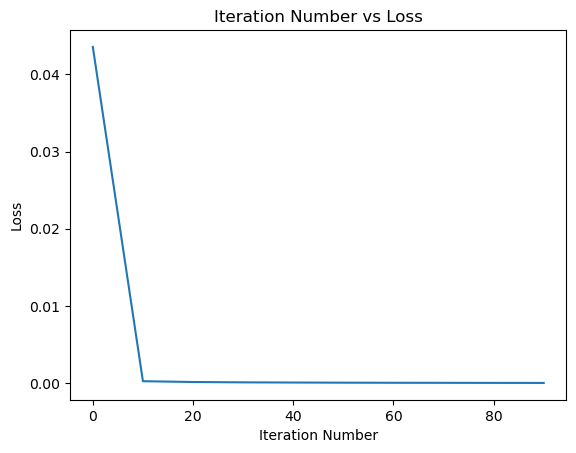

In [19]:
# Test the model
dense1.forward(X_train.reshape(X_train.shape[0], -1))
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
dense4.forward(activation3.output)
predictions = dense4.output * protein_max

# Ensure predictions cover all time steps
predictions_full = np.zeros((len(t_trimmed), predictions.shape[1]))
predictions_full[sequence_length:] = predictions

plt.plot(t_trimmed, Protein_1_trimmed, label='Actual Protein 1')
plt.plot(t_trimmed, Protein_2_trimmed, label='Actual Protein 2')
plt.plot(t_trimmed, Protein_3_trimmed, label='Actual Protein 3')
plt.plot(t_trimmed, predictions_full[:, 0], label='Predicted Protein 1', linestyle='dashed')
plt.plot(t_trimmed, predictions_full[:, 1], label='Predicted Protein 2', linestyle='dashed')
plt.plot(t_trimmed, predictions_full[:, 2], label='Predicted Protein 3', linestyle='dashed')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Protein Concentration")
plt.title("Fitting of model curve")
plt.show()

plt.plot(epoch_data, loss_history)
plt.xlabel("Iteration Number")
plt.ylabel("Loss")
plt.title("Iteration Number vs Loss")
plt.show()


In [20]:
## try with DIFFERENT ACTIVATION FUNCTIONS

In [21]:
# Define the batch size
batch_size = 32

# Neural Network Architecture
dense1 = Layer_Dense(X_train.shape[1], 300)
activation1 = Activation_tanh()
dense2 = Layer_Dense(300, 300)
activation2 = Activation_tanh()
dense3 = Layer_Dense(300, 300)
activation3 = Activation_tanh()
dense4 = Layer_Dense(300, y_train.shape[1])

loss_function = Loss_MeanSquaredError()

learning_rate = 0.01
epochs = 2000
epoch_data = []
loss_history = []

# Helper function to create mini-batches
def create_mini_batches(X, y, batch_size):
    mini_batches = []
    data = np.hstack((X, y))
    np.random.shuffle(data)
    n_minibatches = data.shape[0] // batch_size
    for i in range(n_minibatches):
        mini_batch = data[i * batch_size:(i + 1) * batch_size, :]
        X_mini = mini_batch[:, :-y.shape[1]]
        y_mini = mini_batch[:, -y.shape[1]:]
        mini_batches.append((X_mini, y_mini))
    if data.shape[0] % batch_size != 0:
        mini_batch = data[n_minibatches * batch_size:, :]
        X_mini = mini_batch[:, :-y.shape[1]]
        y_mini = mini_batch[:, -y.shape[1]:]
        mini_batches.append((X_mini, y_mini))
    return mini_batches

for epoch in range(epochs):
    mini_batches = create_mini_batches(X_train, y_train, batch_size)
    epoch_loss = 0
    for mini_batch in mini_batches:
        X_mini, y_mini = mini_batch
        # Forward pass
        dense1.forward(X_mini)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
        dense3.forward(activation2.output)
        activation3.forward(dense3.output)
        dense4.forward(activation3.output)
        predictions = dense4.output

        # Calculate the loss
        loss = loss_function.calculate(predictions, y_mini)
        epoch_loss += loss

        # Backpropagation
        loss_function.backward(predictions, y_mini)
        dense4.backward(loss_function.dinputs)
        activation3.backward(dense4.dinputs)
        dense3.backward(activation3.dinputs)
        activation2.backward(dense3.dinputs)
        dense2.backward(activation2.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)

        # Update weights and biases
        dense4.weights -= learning_rate * dense4.dweights
        dense4.biases -= learning_rate * dense4.dbiases
        dense3.weights -= learning_rate * dense3.dweights
        dense3.biases -= learning_rate * dense3.dbiases
        dense2.weights -= learning_rate * dense2.dweights
        dense2.biases -= learning_rate * dense2.dbiases
        dense1.weights -= learning_rate * dense1.dweights
        dense1.biases -= learning_rate * dense1.dbiases

    epoch_loss /= len(mini_batches)
    if epoch % 100 == 0:
        epoch_data.append(epoch)
        loss_history.append(epoch_loss)
        print(f'Epoch {epoch}, Loss: {epoch_loss}')

# Test the model
dense1.forward(X_train)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
dense4.forward(activation3.output)
predictions = dense4.output * np.max(Protein_1)

plt.plot(t, Protein_1, label='Actual Protein 1')
plt.plot(t, Protein_2, label='Actual Protein 2')
plt.plot(t, Protein_3, label='Actual Protein 3')
plt.plot(t, predictions[:, 0], label='Predicted Protein 1', linestyle='dashed')
plt.plot(t, predictions[:, 1], label='Predicted Protein 2', linestyle='dashed')
plt.plot(t, predictions[:, 2], label='Predicted Protein 3', linestyle='dashed')
plt.legend()
plt.show()

plt.plot(epoch_data, loss_history)
plt.show()


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)